<a href="https://colab.research.google.com/github/PytorchLightning/pytorch-lightning/blob/master/notebooks/05-trainer-flags-overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Lightning Flags ⚡🚩

In this notebook, we'll go over the flags available in the `Trainer` object. Note that not everything will work in the Colab environment (multi-gpu, etc). This notebook accompanies the Trainer videos we'll be putting out.

---
  - Give us a ⭐ [on Github](https://www.github.com/PytorchLightning/pytorch-lightning/)
  - Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/latest/)
  - Join us [on Slack](https://join.slack.com/t/pytorch-lightning/shared_invite/zt-pw5v393p-qRaDgEk24~EjiZNBpSQFgQ)

--- 
### Setup  
First thing first, we need to install Lightning. Simply ```pip install pytorch-lightning```

In [ ]:
! pip install pytorch-lightning

In [ ]:
import os

from argparse import ArgumentParser
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy

from torchvision.datasets.mnist import MNIST
from torchvision import transforms

In [ ]:
# ------------
# data
# ------------
pl.seed_everything(1234)
batch_size = 32

# Init DataLoader from MNIST Dataset

dataset = MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transforms.ToTensor())
mnist_train, mnist_val = random_split(dataset, [55000, 5000])

train_loader = DataLoader(mnist_train, batch_size=batch_size)
val_loader = DataLoader(mnist_val, batch_size=batch_size)
test_loader = DataLoader(mnist_test, batch_size=batch_size)


### Simple AutoEncoder Model

Were gonna define a simple Lightning model so we can play with all the settings of the Lightning Trainer.

LightningModule is simply pure Pytorch reorganized into hooks, that represents all the steps in the training process.

You can use LightningModule hooks to control every part of your model, but for the purpose of this video we will use a very simple MNIST classifier, a model that takes 28*28 grayscale images of hand written images, and can predict the digit between 0-9.

The LightningModule can encompass a single model, like an image classifier, or a deep learning system composed of multiple models, like this auto encoder that contains an encoder and a decoder.




In [ ]:
class LitAutoEncoder(pl.LightningModule):

    def __init__(self, batch_size=32, lr=1e-3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 28 * 28)
        )
        self.batch_size=batch_size
        self.learning_rate=lr

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log('val_loss', loss)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

You'll notice the LightningModule doesn't have epoch and batch loops, we're not calling model.train() and model.eval(), and no mentions of CUDA or hardware. That's because it is all automated by the Lightning Trainer. All the engineering boilerplate is automated by the trainer: 

*  Training loops
*  Evaluation and test loops
*  Calling model.train(), model.eval(), no_grad at the right time
*  CUDA or to_device calls

It also allows you to train your models on different hardware like GPUs and TPUs without changing your code!


### To use the lightning trainer simply:

1. init your LightningModule and datasets

2. init lightning trainer

3. call trainer.fit


In [ ]:
#####################
# 1. Init Model
#####################

model = LitAutoEncoder()

#####################
# 2. Init Trainer
#####################

# these 2 flags are explained in the later sections...but for short explanation:
# - progress_bar_refresh_rate: limits refresh rate of tqdm progress bar so Colab doesn't freak out
# - max_epochs: only run 2 epochs instead of default of 1000
trainer = pl.Trainer(progress_bar_refresh_rate=20, max_epochs=2)

#####################
# 3. Train
#####################
trainer.fit(model, train_loader, val_loader)

Our model is training just like that, using the Lightning defaults. The beauty of Lightning is that everything is easily configurable.
In our next videos were going to show you all the ways you can control your Trainer to do things like controlling your training, validation and test loops, running on GPUs and TPUs, checkpointing, early stopping, and a lot more.


# Training loop and eval loop Flags


To really scale up your networks, you can use accelerators like GPUs. GPUs or Graphical Processing Units, parallelize matrix multiplications which enable speed ups of at least 100x over training on CPUs.

Let's say you have a machine with 8 GPUs on it. You can set this flag to 1, 4, or 8 GPUs and lightning will automatically distribute your training for you.

```
trainer = pl.Trainer(gpus=1)
```

---------

Lightning makes your code hardware agnostic... This means, you can switch between CPUs, GPUs without code changes.

However, it requires forming good PyTorch habits:

1. First, remove the .cuda() or .to() calls in your code.
2. Second, when you initialize a new tensor, set the device=self.device in the call since every lightningModule knows what gpu index or TPU core it is on.

You can also use type_as and or you can register the tensor as a buffer in your module’s __init__ method with register_buffer().

```
# before lightning
def forward(self, x):
    z = torch.Tensor(2, 3)
    z = z.cuda(0)

# with lightning
def forward(self, x):
    z = torch.Tensor(2, 3)
    z = z.type_as(x, device=self.device)
```


```
class LitModel(LightningModule):

    def __init__(self):
        ...
        self.register_buffer("sigma", torch.eye(3))
        # you can now access self.sigma anywhere in your module
```

Lightning Trainer automates all the engineering boilerplate like iterating over epochs and batches, training eval and test loops, CUDA and to(device) calls, calling model.train and model.eval.

You still have full control over the loops, by using the following trainer flags:

## Calling validation steps
Sometimes, training an epoch may be pretty fast, like minutes per epoch. In this case, you might not need to validate on every epoch. Instead, you can actually validate after a few epochs.

Use `check_val_every_n_epoch` flag to control the frequency of validation step:

In [ ]:
# run val loop every 10 training epochs
trainer = pl.Trainer(check_val_every_n_epoch=10)

trainer.fit(model, train_loader, val_loader)

## val_check_interval

In some cases where your epoch is very long, you might want to check validation within an epoch.

You can also run validation step within your training epochs, by setting `val_check_interval` flag.

Set `val_check_interval` to a float between [0.0 to 1.0] to check your validation set within a training epoch. For example, setting it to 0.25 will check your validation set 4 times during a training epoch.

Default is set to 1.0

In [ ]:
# check validation set 4 times during a training epoch
trainer = pl.Trainer(val_check_interval=0.25)

trainer.fit(model, train_loader, val_loader)

When you have iterable data sets, or when streaming data for production use cases, it is useful to check the validation set every number of steps. 
Set val_check_interval to an int:

In [ ]:
# check validation set every 1000 training batches
# use this when using iterableDataset and your dataset has no length
# (ie: production cases with streaming data)
trainer = pl.Trainer(val_check_interval=1000)

trainer.fit(model, train_loader, val_loader)

## num_sanity_val_steps 

You may have run into an issue, where you have a bug in your validation loop, but won't catch it until your training loop ends.

and if your training loop takes hours or days, you will waste valuable compute.

Instead, lightning automatically runs through 2 steps of validation in the beginning to catch these kinds of bugs up front.


The `num_sanity_val_steps` flag can help you run n batches of validation before starting the training routine.

You can set it to 0 to turn it off

In [ ]:
# turn it off
trainer = pl.Trainer(num_sanity_val_steps=0)

trainer.fit(model, train_loader, val_loader)

Set it to -1 to check all validation data before training

In [ ]:
# check all validation data
trainer = pl.Trainer(num_sanity_val_steps=-1)

trainer.fit(model, train_loader, val_loader)

Or use any arbitrary number of validation steps

In [ ]:
trainer = pl.Trainer(num_sanity_val_steps=10)

trainer.fit(model, train_loader, val_loader)

## Limit train, validation, and test batches

You can set limits on how much of training, validation and test dataset you want your model to check. This is useful if you have really large validation or tests sets, for debugging or testing something that happens at the end of an epoch.

Set the flag to int to specify the number of batches to run



In [ ]:
# run for only 10 batches
trainer = pl.Trainer(limit_test_batches=10)

trainer.fit(model, train_loader, val_loader)

For example, some metrics need to be computed on the entire validation results, such as AUC ROC. 

In [ ]:
trainer = pl.Trainer(limit_val_batches=10)

trainer.fit(model, train_loader, val_loader)

You can use a float to limit the batches be percentage of the set on every epoch

In [ ]:
# run through only 25% of the test set each epoch
trainer = pl.Trainer(limit_test_batches=0.25)

trainer.fit(model, train_loader, val_loader)

# Training on GPUs



To run on 1 GPU set the flag to 1

In [ ]:
trainer = pl.Trainer(gpus=1)

trainer.fit(model, train_loader, val_loader)

to run on 2 or 4 GPUs, set the flag to 2 or 4.

In [ ]:
trainer = pl.Trainer(gpus=2)

trainer.fit(model, train_loader, val_loader)

You can also select which GPU devices to run on, using a list of indices like [1, 4] 

or a string containing a comma separated list of GPU ids like '1,2'


In [ ]:
# list: train on GPUs 1, 4 (by bus ordering)
# trainer = Trainer(gpus='1, 4') # equivalent
trainer = pl.Trainer(gpus=[1, 4])

trainer.fit(model, train_loader, val_loader)

In [ ]:
trainer = pl.Trainer(gpus=list(range(4)))

trainer.fit(model, train_loader, val_loader)

You can use all the GPUs you have available by setting `gpus=-1`

In [ ]:
# trainer = Trainer(gpus='-1') - equivalent
trainer = pl.Trainer(gpus=-1)

trainer.fit(model, train_loader, val_loader)

Lightning uses the PCI bus_id as the index for ordering GPUs.

### `auto_select_gpus`

You can save on GPUs by running in “exclusive mode”, meaning only one process at a time can access them. If your not sure which GPUs you should use when running exclusive mode, Lightning can automatically find unoccupied GPUs for you. 

Simply specify the number of gpus as an integer `gpus=k`, and set the trainer flag `auto_select_gpus=True`. Lightning will automatically help you find k gpus that are not occupied by other processes.

In [ ]:
# enable auto selection (will find two available gpus on system)
trainer = pl.Trainer(gpus=2, auto_select_gpus=True)

trainer.fit(model, train_loader, val_loader)

## analyzing GPU usage

### log_gpu_memory

This is useful to analyze the memory usage of your GPUs.

To get the GPU memory usage for every GPU on the master node, set the flag to log_gpu_memory=all.

Under the hood, lightning uses the nvidia-smi command which may slow your training down.

Your logs can become overwhelmed if you log the usage from many GPUs at once. In this case, you can also set the flag to min_max which will log only the min and max usage across all the GPUs of the master node.

Note that lightning is not logging the usage across all nodes for performance reasons.

In [ ]:
# log all the GPUs (on master node only)
trainer = Trainer(log_gpu_memory='all')

trainer.fit(model, train_loader, val_loader)

To avoid the performance decrease you can also set `log_gpu_memory=min_max` to only log the min and max memory on the master node.


In [ ]:
# log only the min and max memory on the master node
trainer = Trainer(log_gpu_memory='min_max')

trainer.fit(model, train_loader, val_loader)


But what if you want to train on multiple machines and not just one?

# Training on multiple GPUs

Lightning makes your models hardware agnostic, and you can run on GPUs with a flip of a flag. Lightning also supports training on multiple GPUs across many machines.

You can do this by setting the num_nodes flag.

The world size, or the total number of GPUs you are using, will be gpus*num_nodes.

If i set gpus=8 and num_nodes=32 then I will be training on 256 GPUs.

In [ ]:
trainer = pl.Trainer(gpus=8, num_nodes=32)

trainer.fit(model, train_loader, val_loader)

## Accelerators

Under the hood, Lightning uses distributed data parallel (or DDP) by default to distribute training across GPUs.

This Lightning implementation of DDP calls your script under the hood multiple times with the correct environment variables.

Under the hood it's as if you had called your script like this:

1. Each GPU across each node gets its own process.
2. Each GPU gets visibility into a subset of the overall dataset. It will only ever see that subset.
3. Each process inits the model. (Make sure to set the random seed so that each model initializes with the same weights.)
4. Each process performs a full forward and backward pass in parallel.
5. The gradients are synced and averaged across all processes.
6. Each process updates its optimizer.
If you request multiple GPUs or nodes without setting a mode, DDP will be automatically used.


In [ ]:
# ddp = DistributedDataParallel
# trainer = pl.Trainer(gpus=2, num_nodes=2) equivalent
trainer = pl.Trainer(gpus=2, num_nodes=2, accelerator='ddp')

trainer.fit(model, train_loader, val_loader)

DDP is the fastest and recommended way to distribute your training, but you can pass in other backends to `accelerator` trainer flag, when DDP is not supported.

DDP isn't available in
* Jupyter Notebook, Google COLAB, Kaggle, etc.
* If You have a nested script without a root package
* or if Your script needs to invoke .fit or .test multiple times

### DDP_SPAWN

In these cases, you can use `ddp_spawn` instead. `ddp_spawn` is exactly like DDP except that it uses `.spawn()` to start the training processes.

In [ ]:
trainer = pl.Trainer(gpus=2, num_nodes=2, accelerator='ddp_spawn')

trainer.fit(model, train_loader, val_loader)

We STRONGLY discourage this use because it has limitations (due to Python and PyTorch):

* Since .spawn() trains the model in subprocesses, the model on the main process does not get updated.

* Dataloader(num_workers=N), where N is large, bottlenecks training with DDP… ie: it will be VERY slow or won’t work at all. This is a PyTorch limitation.

* Forces everything to be picklable.

DDP is MUCH faster than DDP_spawn. To be able to use DDP we recommend you: 

1. Install a top-level module for your project using setup.py

```
# setup.py
#!/usr/bin/env python

from setuptools import setup, find_packages

setup(name='src',
      version='0.0.1',
      description='Describe Your Cool Project',
      author='',
      author_email='',
      url='https://github.com/YourSeed',  # REPLACE WITH YOUR OWN GITHUB PROJECT LINK
      install_requires=[
            'pytorch-lightning'
      ],
      packages=find_packages()
      )

```

2. Setup your project like so:

```
/project
    /src
        some_file.py
        /or_a_folder
    setup.py
```
3. Install as a root-level package
```
cd /project
pip install -e .
```
4. You can then call your scripts anywhere
```
cd /project/src

python some_file.py --accelerator 'ddp' --gpus 8
```

### DP

If you're using windows, DDP is not supported. You can use `dp` for DataParallel instead: DataParallel uses multithreading, instead of multiprocessing. It splits a batch across k GPUs. That is, if you have a batch of 32 and use DP with 2 gpus, each GPU will process 16 samples, after which the root node will aggregate the results.

DP use is discouraged by PyTorch and Lightning. Use DDP which is more stable and at least 3x faster.


In [ ]:
# dp = DataParallel
trainer = pl.Trainer(gpus=2, accelerator='dp')

trainer.fit(model, train_loader, val_loader)

### DDP2

In certain cases, it’s advantageous to use ***all*** batches on the same machine, instead of a subset. For instance, in self-supervised learning, a common performance boost comes from increasing the number of negative samples.

In this case, we can use DDP2 which behaves like DP in a machine and DDP across nodes. DDP2 does the following:

* Copies a subset of the data to each node.
* Inits a model on each node.
* Runs a forward and backward pass using DP.
* Syncs gradients across nodes.
* Applies the optimizer updates.




In [ ]:
# ddp2 = DistributedDataParallel + dp
trainer = pl.Trainer(gpus=2, num_nodes=2, accelerator='ddp2')

trainer.fit(model, train_loader, val_loader)

- The second mode is ddp_spawn. This works like ddp, but instead of calling your script multiple times, lightning will use multiprocessing spawn to start a subprocess per GPU. 

However, you should be careful of mixing this mode with num_workers > 0 in your dataloaders because it will bottleneck your training. This is a current known limitation of PyTorch which is why we recommend using our ddp implementation instead.



### mocking ddp

Testing or debugging DDP can be hard, so we have a distributed backend that simulates ddp on cpus to make it easier. Set `num_processes` to a number greater than 1 when using accelerator="ddp_cpu" to mimic distributed training on a machine without GPUs. Note that while this is useful for debugging, it will not provide any speedup, since single-process Torch already makes efficient use of multiple CPUs.

In [ ]:
# Simulate DDP for debugging on your GPU-less laptop
trainer = Trainer(accelerator="ddp_cpu", num_processes=2)

trainer.fit(model, train_loader, val_loader)

# Training on TPUS


Another option for accelerating your training is using TPUs.
A TPU is a Tensor processing unit, designed specifically for deep learning. Each TPU has 8 cores where each core is optimized for 128x128 matrix multiplies. Google estimates that 8 TPU cores are about as fast as 4 V100 GPUs!

A TPU pod hosts many TPUs on it. Currently, TPU pod v2 has 2048 cores! You can request a full pod from Google cloud or a “slice” which gives you some subset of those 2048 cores.

At this moment, TPUs are available on Google Cloud (GCP), Google Colab and Kaggle Environments.

Lightning supports training on TPUs without any code adjustments to your model. Just like when using GPUs, Lightning automatically inserts the correct samplers - no need to do this yourself!

Under the hood, lightning uses the XLA framework developed jointly by the facebook and google XLA teams. And we want to recognize their efforts in advancing TPU adoption of PyTorch.

## tpu_cores
To train on TPUs, set the tpu_cores flag.

When using colab or kaggle, the allowed values are 1 or 8 cores. When using google cloud, any value above 8 is allowed.

Your effective batch size is the batch size passed into a dataloader times the total number of tpu cores.

In [ ]:
# int: train on a single core
trainer = pl.Trainer(tpu_cores=1)

trainer.fit(model, train_loader, val_loader)

In [ ]:
# int: train on all cores few cores
trainer = pl.Trainer(tpu_cores=8)

trainer.fit(model, train_loader, val_loader)

You can also choose which TPU core to train on, by passing a list [1-8]. This is not an officially supported use case but we are working with the XLA team to improve this user experience.


In [ ]:
# list: train on a single selected core
trainer = pl.Trainer(tpu_cores=[2])

trainer.fit(model, train_loader, val_loader)

To train on more than 8 cores (ie: a POD), submit this script using the xla_dist script.



```
python -m torch_xla.distributed.xla_dist
--tpu=$TPU_POD_NAME
--conda-env=torch-xla-nightly
--env=XLA_USE_BF16=1
-- python your_trainer_file.py
```



# Advanced distributed training



Lightning supports distributed training across multiple GPUs and TPUs out of the box by setting trainer flags, but it also allows you to control the way sampling is done if you need to.

## replace_sampler_ddp
In PyTorch, you must use torch.nn.DistributedSampler for multi-node or GPU training. The sampler makes sure each GPU sees the appropriate part of your data.

```
# without lightning
def train_dataloader(self):
    dataset = MNIST(...)
    sampler = None

    if self.on_tpu:
        sampler = DistributedSampler(dataset)

    return DataLoader(dataset, sampler=sampler)
```
Lightning adds the correct samplers when needed, so no need to explicitly add samplers. By default it will add `shuffle=True` for train sampler and `shuffle=False` for val/test sampler.

If you want to customize this behaviour, you can set `replace_sampler_ddp=False` and add your own distributed sampler.

(note: For iterable datasets, we don’t do this automatically.)


In [ ]:
sampler = torch.utils.data.distributed.DistributedSampler(dataset, shuffle=False)
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)

trainer = pl.Trainer(gpus=2, num_nodes=2, replace_sampler_ddp=False)

## prepare_data_per_node

When doing multi NODE training, if your nodes share the same file system, then you don't want to download data more than once to avoid possible collisions. 

Lightning automatically calls the prepare_data hook on the root GPU of the master node (ie: only a single GPU).

In some cases where your nodes don't share the same file system, you need to download the data on each node. In this case you can set this flag to true and lightning will download the data on the root GPU of each node.

This flag is defaulted to True.

In [ ]:
trainer = pl.Trainer(gpus=2, num_nodes=2, prepare_data_per_node=False)

trainer.fit(model, train_loader, val_loader)

## sync_batchnorm

Batch norm is computed per GPU/TPU. This flag enables synchronization between batchnorm layers across all GPUs.
It is recommended if you have small batch sizes.


In [ ]:
trainer = Trainer(gpus=4, sync_batchnorm=True)

trainer.fit(model, train_loader, val_loader)

# Debugging flags

Lightning offers a couple of flags to make debugging your models easier:


## Fast Dev Run

To help you save time debugging, your first run should use the fast_dev_run flag.

This won't generate logs or save checkpoints but will touch every line of your code to make sure that it is working as intended.

Think about this flag like a compiler. You make changes to your code, and run Trainer with this flag to verify that your changes are bug free.


In [ ]:
trainer = pl.Trainer(fast_dev_run=True)

trainer.fit(model, train_loader, val_loader)

## overfit_batches

Uses this much data of the training set. If nonzero, will use the same training set for validation and testing. If the training dataloaders have shuffle=True, Lightning will automatically disable it.

Useful for quickly debugging or trying to overfit on purpose.

In [ ]:
# use only 1% of the train set (and use the train set for val and test)
trainer = pl.Trainer(overfit_batches=0.01)

trainer.fit(model, train_loader, val_loader)

In [ ]:
# overfit on 10 of the same batches
trainer = pl.Trainer(overfit_batches=10)

trainer.fit(model, train_loader, val_loader)

Or a float to represent percentage of data to run

In [ ]:
# run through only 25% of the test set each epoch
trainer = pl.Trainer(limit_test_batches=0.25)

trainer.fit(model, train_loader, val_loader)

In the case of multiple test dataloaders, the limit applies to each dataloader individually.


# accumulate_grad_batches




The batch size controls the accuracy of the estimate of the gradients. Small batch size use less memory, but decrease accuracy. When training large models, such as NLP transformers, it is useful to accumulate gradients before calling backwards(). It allows for bigger batch sizes than what can actually fit on a GPU/TPU in a single step.

Use accumulate_grad_batches to accumulate gradients every k batches or as set up in the dict. Trainer also calls optimizer.step() for the last indivisible step number.

For example, set accumulate_grad_batches to 4 to accumulate every 4 batches. In this case the effective batch size is batch_size*4, so if your batch size is 32, effectively it will be 128.

In [ ]:
# accumulate every 4 batches (effective batch size is batch*4)
trainer = pl.Trainer(accumulate_grad_batches=4)

trainer.fit(model, train_loader, val_loader)

You can also pass a dictionary to specify different accumulation per epoch. We can set it to `{5: 3, 10: 20}` to have no accumulation for epochs 1 to 4, accumulate 3 batches for epoch 5 to 10, and 20 batches after that.

In [ ]:
# no accumulation for epochs 1-4. accumulate 3 for epochs 5-10. accumulate 20 after that
trainer = pl.Trainer(accumulate_grad_batches={5: 3, 10: 20})

trainer.fit(model, train_loader, val_loader)

# 16 bit precision



Most deep learning frameworks like PyTorch, train with 32-bit floating point arithmetic. 

But many models can still achieve full accuracy using half the precision.

In 2017, NVIDIA researchers successfully used a combination of 32 and 16 bit precision (also known as mixed precision) and achieved the same accuracy as 32 bit precision training.

The main two advantages are:

- a reduction in memory requirements which enables larger batch sizes and models.
- and a speed up in compute. On ampere, turing and volta architectures 16 bit precision models can train at least 3 times faster.

As of PyTorch 1.6, NVIDIA and Facebook moved mixed precision functionality into PyTorch core as the AMP package, torch.cuda.amp. 

This package supersedes the apex package developed by NVIDIA.

## precision

Use precision flag to switch between full precision (32) to half precision (16). Can be used on CPU, GPU or TPUs.

When using PyTorch 1.6+ Lightning uses the native amp implementation to support 16-bit.

If used on TPU will use torch.bfloat16 but tensor printing will still show torch.float32

In [ ]:
# 16-bit precision
trainer = pl.Trainer(gpus=1, precision=16)

trainer.fit(model, train_loader, val_loader)

In earlier version of Lightning, we use NVIDIA Apex for 16-bit precision. Apex was the first library to attempt 16-bit and the automatic mixed precision library (amp), has since been merged into core PyTorch as of 1.6.

If you insist in using Apex, you can set the amp_backend flag to 'apex' and install Apex on your own.

In [ ]:
trainer = pl.Trainer(gpus=1, precision=16, amp_backend='apex')

trainer.fit(model, train_loader, val_loader)

## amp_level
Apex includes 4 optimization levels:
O0 (FP32 training)
O1 (Conservative Mixed Precision): only some whitelist ops are done in FP16.
O2 (Fast Mixed Precision): this is the standard mixed precision training. It maintains FP32 master weights and optimizer.step acts directly on the FP32 master weights.
O3 (FP16 training): full FP16. Passing keep_batchnorm_fp32=True can speed things up as cudnn batchnorm is faster anyway.


In [ ]:
# default used by the Trainer
trainer = pl.Trainer(gpus=1, precision=16, amp_backend='apex', amp_level='O2')

trainer.fit(model, train_loader, val_loader)

# `auto_scale_batch_size`

 



Lightning can help you improve your model by using auto_scale_batch_size flag, which tries to find the largest batch size that fits into memory, before you start your training.
Larger batch size often yields better estimates of gradients, but may also result in longer training time. 

Set it to True to initially run a batch size finder trying to find the largest batch size that fits into memory. The result will be stored in self.batch_size in the LightningModule.


In [ ]:
trainer = pl.Trainer(auto_scale_batch_size=True)

trainer.tune(model, train_dataloader=train_loader, val_dataloaders=val_loader)

You can set the value to `power`. `power` scaling starts from a batch size of 1 and keeps doubling the batch size until an out-of-memory (OOM) error is encountered.


In [ ]:
trainer = pl.Trainer(auto_scale_batch_size='power')

trainer.tune(model, train_dataloader=train_loader, val_dataloaders=val_loader)

You can also set it to `binsearch`, that continues to finetune the batch size by performing a binary search.


In [ ]:
# run batch size scaling, result overrides hparams.batch_size
trainer = pl.Trainer(auto_scale_batch_size='binsearch')

trainer.tune(model, train_dataloader=train_loader, val_dataloaders=val_loader)

This feature expects that a batch_size field in the hparams of your model, i.e., model.hparams.batch_size should exist and will be overridden by the results of this algorithm. 

Additionally, your train_dataloader() method should depend on this field for this feature to work.

The algorithm in short works by:
1. Dumping the current state of the model and trainer

2. Iteratively until convergence or maximum number of tries max_trials (default 25) has been reached:
* Call fit() method of trainer. This evaluates steps_per_trial (default 3) number of training steps. Each training step can trigger an OOM error if the tensors (training batch, weights, gradients etc.) allocated during the steps have a too large memory footprint.
  * If an OOM error is encountered, decrease the batch size
  * Else increase it.
* How much the batch size is increased/decreased is determined by the chosen strategy.

3. The found batch size is saved to model.hparams.batch_size

4. Restore the initial state of model and trainer



# `auto_lr_find`





Selecting a good learning rate for your deep learning training is essential for both better performance and faster convergence.

Even optimizers such as Adam that are self-adjusting the learning rate can benefit from more optimal choices.

To reduce the amount of guesswork concerning choosing a good initial learning rate, you can use Lightning auto learning rate finder.

The learning rate finder does a small run where the learning rate is increased after each processed batch and the corresponding loss is logged. The result of this is a lr vs. loss plot that can be used as guidance for choosing an optimal initial lr.


warning: For the moment, this feature only works with models having a single optimizer. LR support for DDP is not implemented yet, it is coming soon.


***auto_lr_find=***

In the most basic use case, this feature can be enabled during trainer construction with Trainer(auto_lr_find=True).
When .fit(model) is called, the LR finder will automatically run before any training is done. The lr that is found and used will be written to the console and logged together with all other hyperparameters of the model.

In [ ]:
# default used by the Trainer (no learning rate finder)
trainer = pl.Trainer(mnist_model, auto_lr_find=False)

This flag sets your learning rate which can be accessed via self.lr or self.learning_rate.


In [ ]:
class LitModel(LightningModule):

    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=(self.lr or self.learning_rate))

# finds learning rate automatically
# sets hparams.lr or hparams.learning_rate to that learning rate
trainer = pl.Trainer(mnist_model, auto_lr_find=True)

trainer.tune(model, train_dataloader=train_loader, val_dataloaders=val_loader)


To use an arbitrary value set it as auto_lr_find


In [ ]:
trainer = pl.Trainer(mnist_model, auto_lr_find='my_value')

trainer.tune(model, train_dataloader=train_loader, val_dataloaders=val_loader)

Under the hood, when you call tune it runs the learning rate finder.

If you want to inspect the results of the learning rate finder before doing any actual training or just play around with the parameters of the algorithm, this can be done by invoking the lr_find method of the trainer. A typical example of this would look like


```
trainer = pl.Trainer(auto_lr_find=True)

# Run learning rate finder
lr_finder = trainer.lr_find(model)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
model.hparams.lr = new_lr

# Fit model
trainer.fit(model)
```

The figure produced by lr_finder.plot() should look something like the figure below. It is recommended to not pick the learning rate that achieves the lowest loss, but instead something in the middle of the sharpest downward slope (red point). This is the point returned py lr_finder.suggestion().

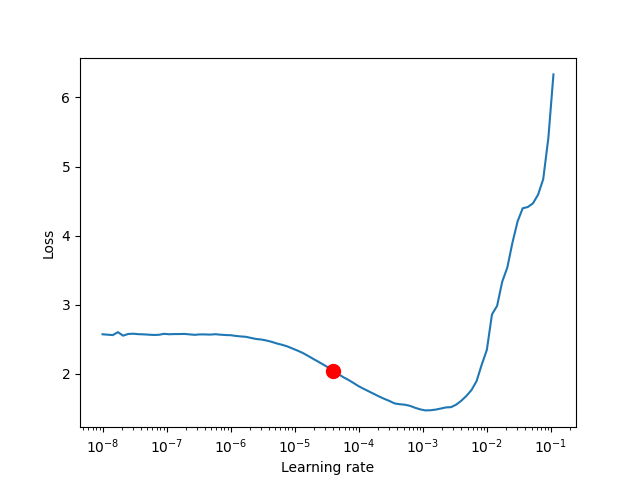

# `benchmark`



You can try to speed your system by setting `benchmark=True`, which enables cudnn.benchmark. This flag is likely to increase the speed of your system if your input sizes don’t change. This flag makes cudnn auto-tuner look for the optimal set of algorithms for the given hardware configuration. This usually leads to faster runtime.
But if your input sizes changes at each iteration, then cudnn will benchmark every time a new size appears, possibly leading to worse runtime performances.

In [ ]:
trainer = pl.Trainer(gpus=1, benchmark=True)

trainer.fit(model, train_loader, val_loader)

# `deterministic`



PyTorch does not guarantee reproducible results, even when using identical seeds. To guarentee reproducible results, you can remove most of the randomness from your process by setting the `deterministic` flag to True.

Note that it might make your system slower.

In [ ]:
trainer = pl.Trainer(gpus=1, deterministic=True)

trainer.fit(model, train_loader, val_loader)

# Exploding and vanishing gradients

## track_grad_norm

You can debug your grad norm to identify exploding or vanishing gradients using the `track_grad_norm` flag.

Set value to 2 to track the 2-norm. or p to any p-norm.

In [ ]:
# track the 2-norm
trainer = pl.Trainer(track_grad_norm=2)

trainer.fit(model, train_loader, val_loader)

May be set to ‘inf’ infinity-norm.

In [ ]:
trainer = pl.Trainer(track_grad_norm='inf')

trainer.fit(model, train_loader, val_loader)

## Gradient clipping


Exploding gradients refer to the problem that the gradients get too large and overflow in training, making the model unstable. Gradient clipping will ‘clip’ the gradients or cap them to a Threshold value to prevent the gradients from getting too large. To avoid this, we can set `gradient_clip_val` (default is set to 0.0).

[when to use it, what are relevant values]

In [ ]:
trainer = pl.Trainer(gradient_clip_val=0.1)

trainer.fit(model, train_loader, val_loader)

# truncated_bptt_steps



If you have a large recurrent model, you can use truncated_bptt_steps flag to split up the backprop over portions of the sequence. This flag will automatically truncate your batches and the trainer will apply Truncated Backprop to it.

Make sure your batches have a sequence dimension.

Lightning takes care of splitting your batch along the time-dimension.
```
# we use the second as the time dimension
# (batch, time, ...)
sub_batch = batch[0, 0:t, ...]
Using this feature requires updating your LightningModule’s pytorch_lightning.core.LightningModule.training_step() to include a hiddens arg with the hidden

# Truncated back-propagation through time
def training_step(self, batch, batch_idx, hiddens):
    # hiddens are the hiddens from the previous truncated backprop step
    out, hiddens = self.lstm(data, hiddens)

    return {
        "loss": ...,
        "hiddens": hiddens  # remember to detach() this
    }
```

In [ ]:
# backprop every 5 steps in a batch
trainer = pl.Trainer(truncated_bptt_steps=5)

trainer.fit(model, train_loader, val_loader)

To modify how the batch is split, override pytorch_lightning.core.LightningModule.tbptt_split_batch():

```
class LitMNIST(LightningModule):
    def tbptt_split_batch(self, batch, split_size):
        # do your own splitting on the batch
        return splits
```


# reload_dataloaders_every_epoch


Set to True to reload dataloaders every epoch (instead of loading just once in the beginning of training).

```
# if False (default)
train_loader = model.train_dataloader()
for epoch in epochs:
    for batch in train_loader:
        ...

# if True
for epoch in epochs:
    train_loader = model.train_dataloader()
    for batch in train_loader:

```

In [ ]:
trainer = pl.Trainer(reload_dataloaders_every_epoch=True)

trainer.fit(model, train_loader, val_loader)

# Callbacks



Lightning Callbacks are self-contained programs that can be reused across projects.
Callbacks should capture NON-ESSENTIAL logic that is NOT required for your LightningModule to run. Lightning includes some a few built-in callbacks that can be used with flags like early stopping and Model Checkpointing, but you can also create your own callbacks to add any functionality to your models.

The callback API includes hooks that allow you to add logic at every point of your training:
setup, teardown, on_epoch_start, on_epoch_end, on_batch_start, on_batch_end, on_init_start, on_keyboard_interrupt etc. 



## callbacks

Use **callbacks=** to pass a list of user defined callbacks. These callbacks DO NOT replace the built-in callbacks (loggers or EarlyStopping). 

In this example, we create a dummy callback that prints a message when training starts and ends, using on_train_start and on_train_end hooks.

In [ ]:
from pytorch_lightning.callbacks import Callback

class PrintCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training is started!")
    def on_train_end(self, trainer, pl_module):
        print("Training is done.")

# a list of callbacks
callbacks = [PrintCallback()]
trainer = pl.Trainer(callbacks=callbacks)

trainer.fit(model, train_loader, val_loader)

# Model checkpointing



Checkpoints capture the exact value of all parameters used by a model.

Checkpointing your training allows you to resume a training process in case it was interrupted, fine-tune a model or use a pre-trained model for inference without having to retrain the model.

Lightning automates saving and loading checkpoints so you restore a training session, saving all the required parameters including: 
* 16-bit scaling factor (apex)
* Current epoch
* Global step
* Model state_dict
* State of all optimizers
* State of all learningRate schedulers
* State of all callbacks
* The hyperparameters used for that model if passed in as hparams (Argparse.Namespace)

By default Lightning will save a checkpoint in the working directory, which will be updated every epoch.

### Automatic saving
By default Lightning will save a checkpoint in the end of the first epoch in the working directory, which will be updated every epoch.

In [ ]:
# default used by the Trainer
trainer = pl.Trainer(default_root_dir=os.getcwd())

trainer.fit(model, train_loader, val_loader)

To change the checkpoint path pass in **default_root_dir=**

In [ ]:
trainer = pl.Trainer(default_root_dir='/your/path/to/save/checkpoints')

trainer.fit(model, train_loader, val_loader)


You can also have Lightning update your checkpoint based on a specific metric that you are logging (using self.log), by passing the key to `monitor=`. For example, if we want to save checkpoint based on the validation loss, logged as `val_loss`, you can pass:


```
checkpoint_callback = ModelCheckpoint(
    filepath=os.getcwd(),
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix=''
)
```


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

trainer = pl.Trainer(callbacks=[ModelCheckpoint(monitor='val_loss')])

trainer.fit(model, train_loader, val_loader)

You can modify the behavior of checkpointing by creating your own callback, and passing it to the trainer. 
You can control
* filepath- where logs are saved
* save_top_k- save k top models
* verbose
* monitor- the metric to monitor
* mode
* prefix



In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

# DEFAULTS used by the Trainer
checkpoint_callback = ModelCheckpoint(
    filepath=os.getcwd(),
    save_top_k=3,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix='',
)

trainer = Trainer(callbacks=[checkpoint_callback])

trainer.fit(model, train_loader, val_loader)

You can disable checkpointing it by passing



In [ ]:
trainer = Trainer(checkpoint_callback=False)

### Manual saving

You can manually save checkpoints and restore your model from the checkpointed state.


In [ ]:
trainer.fit(model)
trainer.save_checkpoint("example.ckpt")
new_model = LitAutoEncoder.load_from_checkpoint(checkpoint_path="example.ckpt")

### Checkpoint Loading
To load a model along with its weights, biases and module_arguments use following method:



In [ ]:
model = LitAutoEncoder.load_from_checkpoint(PATH)

print(model.learning_rate)
# prints the learning_rate you used in this checkpoint

model.eval()
y_hat = model(x)

But if you don’t want to use the values saved in the checkpoint, pass in your own here

In [ ]:
class LitAutoEncoder(LightningModule):

    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.save_hyperparameters()
        self.l1 = nn.Linear(self.hparams.in_dim, self.hparams.out_dim)

you can restore the model like this



In [ ]:
# if you train and save the model like this it will use these values when loading
# the weights. But you can overwrite this
LitAutoEncoder(in_dim=32, out_dim=10)

# uses in_dim=32, out_dim=10
model = LitAutoEncoder.load_from_checkpoint(PATH)


In [ ]:
# uses in_dim=128, out_dim=10
model = LitAutoEncoder.load_from_checkpoint(PATH, in_dim=128, out_dim=10)



## Restoring Training State (resume_from_checkpoint)
If your training was cut short for some reason, you can resume exactly from where you left off using the `resume_from_checkpoint` flag, which will automatically restore model, epoch, step, LR schedulers, apex, etc...

In [ ]:
model = LitAutoEncoder()
trainer = pl.Trainer(resume_from_checkpoint='some/path/to/my_checkpoint.ckpt')

# automatically restores model, epoch, step, LR schedulers, apex, etc...
trainer.fit(model)

## weights_save_path
You can specify a directory for saving weights file using `weights_save_path`.

(If you are using a custom checkpoint callback, the checkpoint callback will override this flag).

In [ ]:
# save to your custom path
trainer = pl.Trainer(weights_save_path='my/path')

trainer.fit(model, train_loader, val_loader)

In [ ]:
# if checkpoint callback used, then overrides the weights path
# **NOTE: this saves weights to some/path NOT my/path
checkpoint = ModelCheckpoint(filepath='some/path')
trainer = pl.Trainer(
    callbacks=[checkpoint],
    weights_save_path='my/path'
)
trainer.fit(model, train_loader, val_loader)

# Early stopping


The EarlyStopping callback can be used to monitor a validation metric and stop the training when no improvement is observed, to help you avoid overfitting.

To enable Early Stopping you can init the EarlyStopping callback, and pass it to `callbacks=` trainer flag. The callback will look for a logged metric to early stop on.



In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

trainer = pl.Trainer(callbacks=[EarlyStopping('val_loss')])

trainer.fit(model, train_loader, val_loader)

You can customize the callback using the following params:


In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.00,
   patience=3,
   verbose=False,
   mode='max'
)
trainer = pl.Trainer(callbacks=[early_stop_callback])

trainer.fit(model, train_loader, val_loader)

The EarlyStopping callback runs at the end of every validation check, which, under the default configuration, happens after every training epoch. However, the frequency of validation can be modified by setting various parameters on the Trainer, for example check_val_every_n_epoch and val_check_interval. It must be noted that the patience parameter counts the number of validation checks with no improvement, and not the number of training epochs. Therefore, with parameters check_val_every_n_epoch=10 and patience=3, the trainer will perform at least 40 training epochs before being stopped.

# Logging

Lightning has built in integration with various loggers such as TensorBoard, wandb, commet, etc.


You can pass any metrics you want to log during training to `self.log`, such as loss or accuracy. Similarly, pass in to self.log any metric you want to log during validation step.

These values will be passed in to the logger of your choise. simply pass in any supported logger to logger trainer flag.



Use the as`logger=` trainer flag to pass in a Logger, or iterable collection of Loggers, for experiment tracking.





In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger

# default logger used by trainer
logger = TensorBoardLogger(
    save_dir=os.getcwd(),
    version=1,
    name='lightning_logs'
)
trainer = pl.Trainer(logger=logger)

trainer.fit(model, train_loader, val_loader)

Lightning supports the use of multiple loggers, just pass a list to the Trainer.



In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger, TestTubeLogger
logger1 = TensorBoardLogger('tb_logs', name='my_model')
logger2 = TestTubeLogger('tb_logs', name='my_model')
trainer = pl.Trainer(logger=[logger1, logger2])

## flush_logs_every_n_steps

Use this flag to determine when logging to disc should happen.

In [ ]:
trainer = pl.Trainer(flush_logs_every_n_steps=100)

trainer.fit(model, train_loader, val_loader)


## log_every_n_steps
How often to add logging rows (does not write to disk)



In [ ]:
trainer = pl.Trainer(log_every_n_steps=1000)

trainer.fit(model, train_loader, val_loader)

# info logging

### default_root_dir

---



Default path for logs and weights when no logger or pytorch_lightning.callbacks.ModelCheckpoint callback passed. On certain clusters you might want to separate where logs and checkpoints are stored. If you don’t then use this argument for convenience. Paths can be local paths or remote paths such as s3://bucket/path or ‘hdfs://path/’. Credentials will need to be set up to use remote filepaths.

## weights_summary
Prints a summary of the weights when training begins. Default is set to `top`- print summary of top level modules.

Options: ‘full’, ‘top’, None.

In [ ]:

# print full summary of all modules and submodules
trainer = pl.Trainer(weights_summary='full')

trainer.fit(model, train_loader, val_loader)

In [ ]:
# don't print a summary
trainer = Trainer(weights_summary=None)

trainer.fit(model, train_loader, val_loader)

# progress bar

## process_position

Orders the progress bar. Useful when running multiple trainers on the same node.

(This argument is ignored if a custom callback is passed to callbacks)



In [ ]:
# default used by the Trainer
trainer = pl.Trainer(process_position=0)

trainer.fit(model, train_loader, val_loader)

## progress_bar_refresh_rate

How often to refresh the progress bar (in steps). In notebooks, faster refresh rates (lower number) is known to crash them because of their screen refresh rates, so raise it to 50 or more.

In [ ]:
# default used by the Trainer
trainer = pl.Trainer(progress_bar_refresh_rate=1)

trainer.fit(model, train_loader, val_loader)

In [ ]:
# disable progress bar
trainer = Trainer(progress_bar_refresh_rate=0)

trainer.fit(model, train_loader, val_loader)

# profiler

In [ ]:
# to profile standard training events
trainer = pl.Trainer(profiler=True)

trainer.fit(model, train_loader, val_loader)

You can also use Lightning AdvancedProfiler if you want more detailed information about time spent in each function call recorded during a given action. The output is quite verbose and you should only use this if you want very detailed reports.



In [ ]:
from pytorch_lightning.profiler import AdvancedProfiler

trainer = Trainer(profiler=AdvancedProfiler())

trainer.fit(model, train_loader, val_loader)

<code style="color:#792ee5;">
    <h1> <strong> Congratulations - Time to Join the Community! </strong>  </h1>
</code>

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning movement, you can do so in the following ways!

### Star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool tools we're building.

* Please, star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning)

### Join our [Slack](https://join.slack.com/t/pytorch-lightning/shared_invite/zt-pw5v393p-qRaDgEk24~EjiZNBpSQFgQ)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself and share your interests in `#general` channel

### Interested by SOTA AI models ! Check out [Bolt](https://github.com/PyTorchLightning/lightning-bolts)
Bolts has a collection of state-of-the-art models, all implemented in [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) and can be easily integrated within your own projects.

* Please, star [Bolt](https://github.com/PyTorchLightning/lightning-bolts)

### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) or [Bolt](https://github.com/PyTorchLightning/lightning-bolts) GitHub Issues page and filter for "good first issue". 

* [Lightning good first issue](https://github.com/PyTorchLightning/pytorch-lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/PyTorchLightning/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

<img src="https://github.com/PyTorchLightning/pytorch-lightning/blob/master/docs/source/_static/images/logo.png?raw=true" width="800" height="200" />